# Measuring application

In [2]:
# Imports
import cv2
import imutils
import numpy as np
from imutils import contours
from imutils import perspective
from scipy.spatial import distance as dist
import matplotlib.pyplot as plt

In [3]:
# Load the image
image = cv2.imread('../data/lesson10_measuring_image_1.png')

In [7]:
# Convert it to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Blur it slightly
gray_gb = cv2.GaussianBlur(gray, (7, 7), 0)
    
# Perform edge detection
edged = cv2.Canny(gray_gb, 50, 100)
    
# Perform a dilation + erosion to close gaps in between object edges
edged_d = cv2.dilate(edged, None, iterations=1)
edged_e = cv2.erode(edged_d, None, iterations=1)

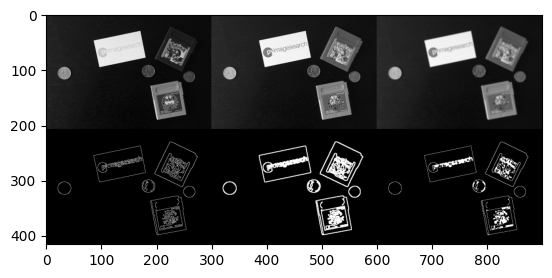

In [8]:
# Show result
rsize = 0.5
result1 = np.concatenate((cv2.resize(image[:, :, 0], (0, 0), None, rsize, rsize),
                        cv2.resize(gray, (0, 0), None, rsize, rsize),
                        cv2.resize(gray_gb, (0, 0), None, rsize, rsize)), axis=1)
result2 = np.concatenate((
                        cv2.resize(edged, (0, 0), None, rsize, rsize), cv2.resize(edged_d, (0, 0), None, rsize, rsize),
                        cv2.resize(edged_e, (0, 0), None, rsize, rsize)), axis=1)
result = np.concatenate((result1, result2), axis=0)
plt.imshow(result, cmap='gray')
plt.show()

In [9]:
# Find contours in the edge map
cnts = cv2.findContours(edged_e.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# Sort the contours from left-to-right and initialize the 'pixels per metric' calibration variable
(cnts, _) = contours.sort_contours(cnts)

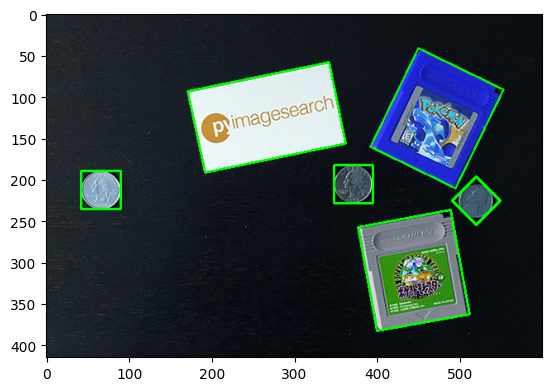

In [10]:
# Loop over the contours individually
boxes = []
for c in cnts:
    
    # If the contour is not sufficiently large, ignore it
    if cv2.contourArea(c) < 100:
        continue
    
    # Compute the rotated bounding box of the contour
    box = cv2.minAreaRect(c)
    box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
    box = np.array(box, dtype="int")
    
    # Order the points in the contour such that they appear in top-left, top-right, bottom-right, and bottom-left
    box = perspective.order_points(box)
    boxes.append(box)
        
    # Draw the outline of the rotated bounding box
    cv2.drawContours(image, [box.astype("int")], -1, (0, 255, 0), 2)
    plt.imshow(image)

plt.show()

In [11]:
# Takes the mean of two points
def midpoint(ptA, ptB):
    return (ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5

In [12]:
# Iterate over boxes
for box in boxes:

    # Unpack the box points
    (tl, tr, br, bl) = box
        
    # Compute the midpoint between the top-left and top-right coordinates
    (tltrX, tltrY) = midpoint(tl, tr)

    # Compute the midpoint between bottom-left and bottom-right coordinates
    (blbrX, blbrY) = midpoint(bl, br)
    
    # Compute the midpoint between the top-left and bottom-left points,
    (tlblX, tlblY) = midpoint(tl, bl)

    # Compute the midpoint between the top-righ and bottom-right
    (trbrX, trbrY) = midpoint(tr, br)
    
    # Draw the midpoints on the image
    cv2.circle(image, (int(tltrX), int(tltrY)), 5, (255, 0, 0), -1)
    cv2.circle(image, (int(blbrX), int(blbrY)), 5, (255, 0, 0), -1)
    cv2.circle(image, (int(tlblX), int(tlblY)), 5, (255, 0, 0), -1)
    cv2.circle(image, (int(trbrX), int(trbrY)), 5, (255, 0, 0), -1)
    
    # Draw lines between the midpoints
    cv2.line(image, (int(tltrX), int(tltrY)), (int(blbrX), int(blbrY)), (255, 0, 255), 2)
    cv2.line(image, (int(tlblX), int(tlblY)), (int(trbrX), int(trbrY)), (255, 0, 255), 2)
    
    # Compute the Euclidean distance between the midpoints
    dA = dist.euclidean((tltrX, tltrY), (blbrX, blbrY))
    dB = dist.euclidean((tlblX, tlblY), (trbrX, trbrY))
    
    # if the pixels per metric has not been initialized, then
    # compute it as the ratio of pixels to supplied metric
    pixelsPerMetric = dB / 24.25700
    print("\nPixels per metric = " + str(pixelsPerMetric))
    
    # Compute the size of the object
    dimA = dA / pixelsPerMetric
    dimB = dB / pixelsPerMetric
    print("\nDimensions = " + str((dimA, dimB)))


Pixels per metric = 1.9788102403429937

Dimensions = (23.246291666666668, 24.257)

Pixels per metric = 7.17546717656834

Dimensions = (13.953262431208517, 24.257)

Pixels per metric = 1.9375850270025146

Dimensions = (23.74089361702128, 24.257)

Pixels per metric = 4.693930018481212

Dimensions = (27.181948536803944, 24.257)

Pixels per metric = 4.7200618936636465

Dimensions = (28.046670982524805, 24.257)

Pixels per metric = 1.690736418717061

Dimensions = (24.257, 24.257)


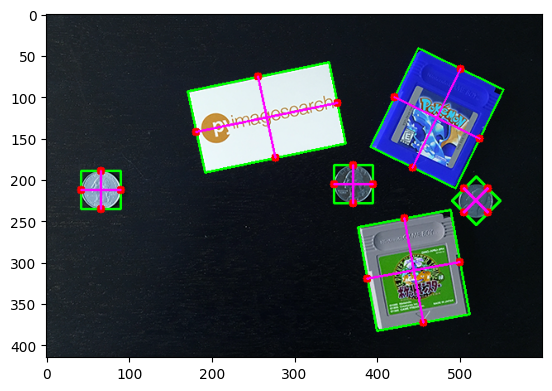

In [13]:
# Show image
plt.imshow(image)
plt.show()